# VAE on HSC images

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from datasets import load_from_disk

from galgenai import VAE, get_device, get_device_name


device = get_device()
print(f"Using device: {get_device_name()}")

Using device: cuda


## Load and inspect data

In [2]:
dataset_raw = load_from_disk("/data/a/cpac/fkeruzore/hsc_mmu/")
dataset_raw = dataset_raw.select_columns(["image"]).with_format("torch")

n_gals = len(dataset_raw)
bands = dataset_raw[0]["image"]["band"]

# dataset.set_transform(lambda data: {"flux": data["image"]["flux"]})
# dataset = dataset.map(lambda x: {"flux": x["image"]["flux"]}, remove_columns=["image"])

# min/max
mins = torch.Tensor(-2 * np.ones(len(bands)))
maxs = torch.Tensor(99 * np.ones(len(bands)))


class FluxDataset(torch.utils.data.Dataset):
    def __init__(
        self,
        hf_dataset,
        nx: int,
        mins: torch.TensorType,
        maxs: torch.TensorType,
    ):
        self.dataset = hf_dataset

        # crop to 128
        self.og_nx2 = self.dataset[0]["image"]["flux"].shape[1] // 2
        self.og_ny2 = self.dataset[0]["image"]["flux"].shape[2] // 2
        self.mins = mins[:, None, None]
        self.maxs = maxs[:, None, None]

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        batch = self.dataset[idx]["image"]["flux"][
            :,
            self.og_nx2 - 64 : self.og_nx2 + 64,
            self.og_ny2 - 64 : self.og_ny2 + 64,
        ]
        return (batch - self.mins) / (self.maxs - self.mins)


dataset = FluxDataset(dataset_raw, nx=128, mins=mins, maxs=maxs)
n_bands, n_x, n_y = dataset[0].shape
assert n_x == n_y
assert len(bands) == n_bands
print(f"Images dimension: {n_bands}*{n_x}*{n_y} ({n_gals} galaxies)")

Images dimension: 5*128*128 (86614 galaxies)


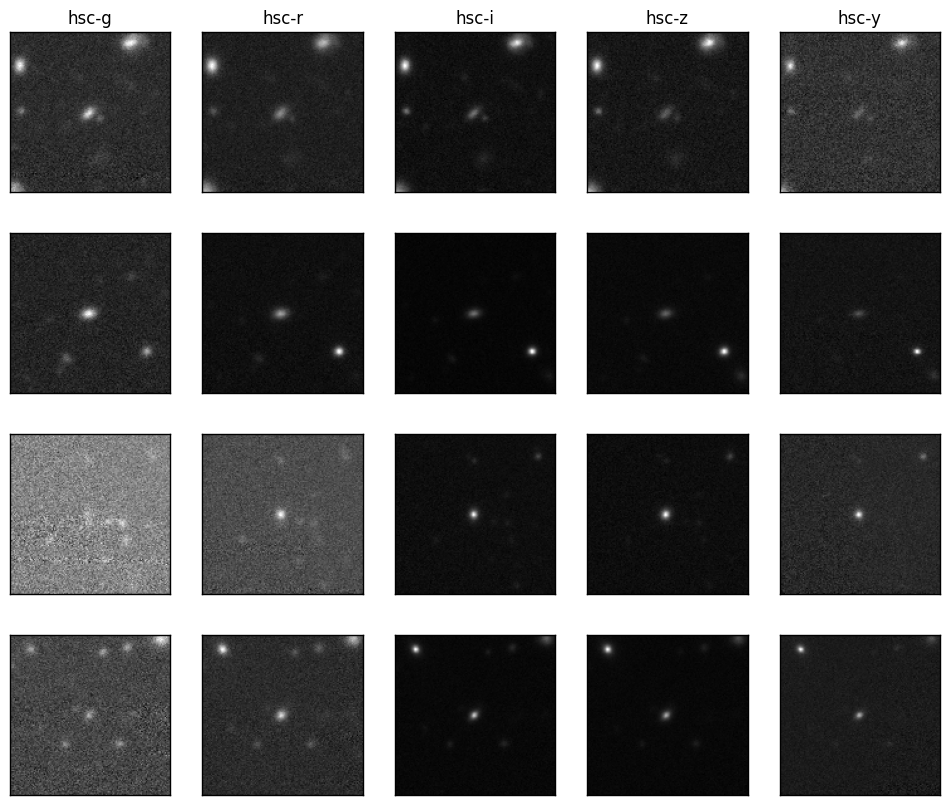

In [3]:
_n_plot = 4
fig, axs = plt.subplots(_n_plot, n_bands, figsize=(12, 10))

for i in range(_n_plot):
    axs_row = axs[i]
    ds = dataset[i]
    for im, band, ax in zip(ds, bands, axs_row, strict=True):
        ax.imshow(im, origin="lower", cmap="gray")
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
        if i == 0:
            ax.set_title(band)

## Define model

In [4]:
model = VAE(in_channels=n_bands, latent_dim=32, input_size=n_x).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model parameters: {num_params:,}")

Model parameters: 66,840,469


In [5]:
x = torch.randn(4, n_bands, n_x, n_y).to(device)  # batch
print(f"Input shape: {x.shape}")

reconstruction, mu, logvar = model(x)
print(f"Reconstruction shape: {reconstruction.shape}")
print(f"Latent mean shape: {mu.shape}")
print(f"Latent log variance shape: {logvar.shape}")

Input shape: torch.Size([4, 5, 128, 128])
Reconstruction shape: torch.Size([4, 5, 128, 128])
Latent mean shape: torch.Size([4, 32])
Latent log variance shape: torch.Size([4, 32])


## Check pre-training outputs

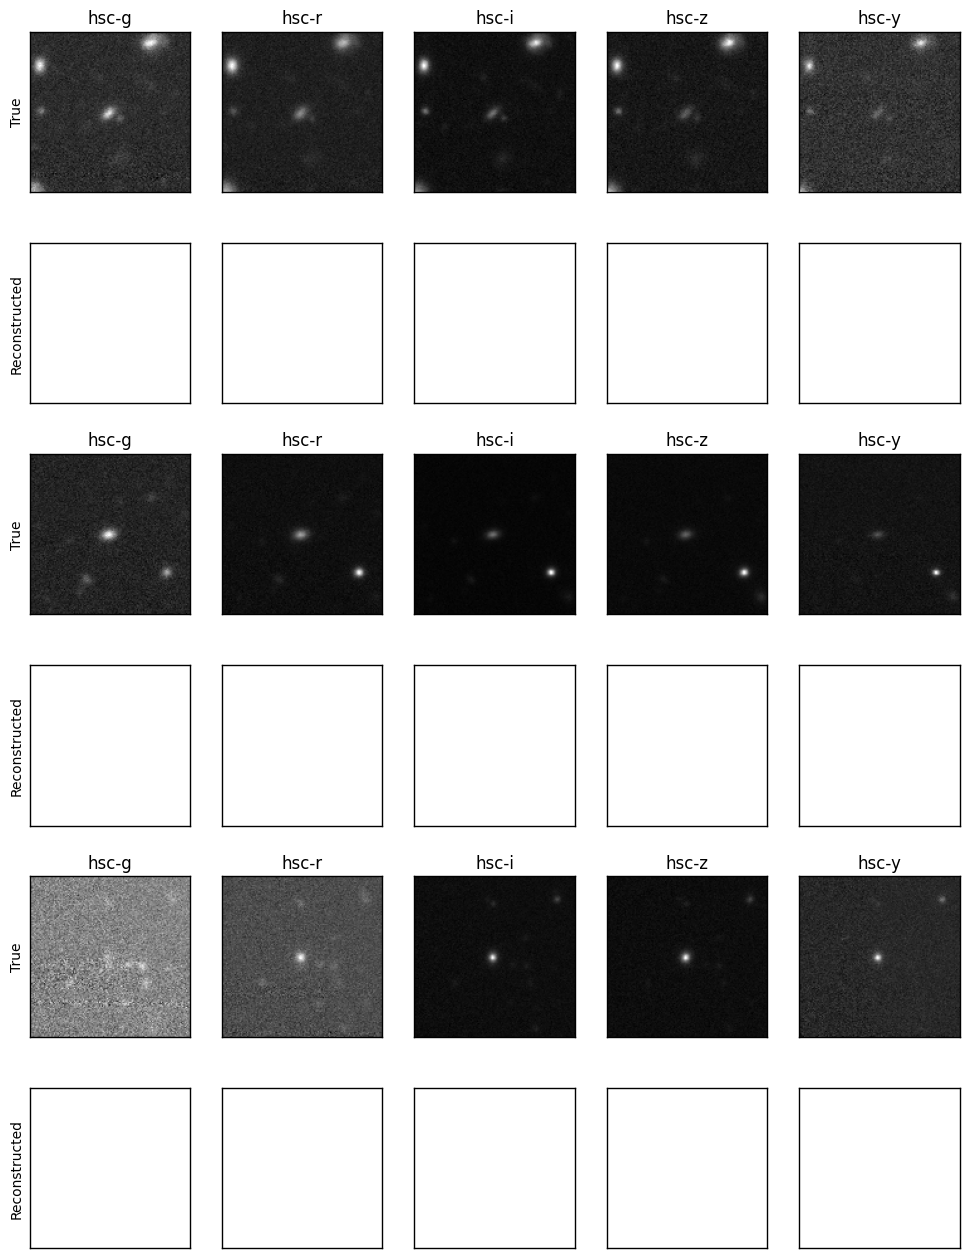

In [6]:
model.eval()
_n_plot = 3

imgs = torch.stack([dataset[i] for i in range(4)]).to(device)
with torch.no_grad():
    recs, _, _ = model(imgs)

fig, axs = plt.subplots(_n_plot * 2, n_bands, figsize=(12, 16))
for i in range(_n_plot):
    axs_row_true = axs[2 * i]
    axs_row_reco = axs[2 * i + 1]

    axs_row_true[0].set_ylabel("True")
    axs_row_reco[0].set_ylabel("Reconstructed")

    for j, band in enumerate(bands):
        minmax = {
            "vmin": imgs[i, j].cpu().min(),
            "vmax": imgs[i, j].cpu().max(),
        }
        axs_row_true[j].imshow(
            imgs[i, j].cpu(), origin="lower", cmap="gray", **minmax
        )
        axs_row_reco[j].imshow(
            recs[i, j].cpu(), origin="lower", cmap="gray", **minmax
        )

        axs_row_true[j].xaxis.set_ticks([])
        axs_row_true[j].yaxis.set_ticks([])
        axs_row_reco[j].xaxis.set_ticks([])
        axs_row_reco[j].yaxis.set_ticks([])
        axs_row_true[j].set_title(band)

## Train

In [9]:
from torch.utils.data import DataLoader, random_split
from galgenai.training import train

BATCH_SIZE = 256
NUM_WORKERS = 4
NUM_EPOCHS = 10

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.75)

dataset_train, dataset_test = random_split(dataset, [0.8, 0.2])

train_loader = DataLoader(
    dataset_train,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)
test_loader = DataLoader(
    dataset_test,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False,
)

train(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    device=device,
    num_epochs=NUM_EPOCHS,
    reconstruction_loss_fn="mse",
    beta=1.0,
)

Training on device: cuda
Number of epochs: 10
Reconstruction loss: mse
Beta: 1.0
Learning rate scheduler: ExponentialLR
------------------------------------------------------------

Epoch 1/10 (lr: 0.001000)


Training:   0%|          | 0/271 [00:00<?, ?it/s]

Training: 100%|██████████| 271/271 [06:13<00:00,  1.38s/it, loss=90.2705, recon=65.8620, kl=24.4086]                 


Epoch 1 Summary - Total Loss: 4403203.2389, Recon Loss: 978.0283, KL Loss: 4402225.1797

Epoch 2/10 (lr: 0.000750)


Training: 100%|██████████| 271/271 [06:07<00:00,  1.36s/it, loss=53.7775, recon=47.9877, kl=5.7897] 


Epoch 2 Summary - Total Loss: 61.0209, Recon Loss: 44.2072, KL Loss: 16.8137

Epoch 3/10 (lr: 0.000563)


Training: 100%|██████████| 271/271 [05:28<00:00,  1.21s/it, loss=46.1344, recon=42.7978, kl=3.3365] 


Epoch 3 Summary - Total Loss: 50.3252, Recon Loss: 44.1126, KL Loss: 6.2126

Epoch 4/10 (lr: 0.000422)


Training: 100%|██████████| 271/271 [04:56<00:00,  1.09s/it, loss=43.2452, recon=38.4192, kl=4.8260] 


Epoch 4 Summary - Total Loss: 48.7616, Recon Loss: 43.9832, KL Loss: 4.7784

Epoch 5/10 (lr: 0.000316)


Training: 100%|██████████| 271/271 [06:20<00:00,  1.40s/it, loss=43.1562, recon=39.5751, kl=3.5812] 


Epoch 5 Summary - Total Loss: 47.2890, Recon Loss: 43.8063, KL Loss: 3.4828

Epoch 6/10 (lr: 0.000237)


Training: 100%|██████████| 271/271 [05:27<00:00,  1.21s/it, loss=21.2630, recon=17.6328, kl=3.6302] 


Epoch 6 Summary - Total Loss: 40.6180, Recon Loss: 37.0044, KL Loss: 3.6135

Epoch 7/10 (lr: 0.000178)


Training: 100%|██████████| 271/271 [06:11<00:00,  1.37s/it, loss=28.2673, recon=25.2187, kl=3.0486] 


Epoch 7 Summary - Total Loss: 18.0235, Recon Loss: 14.3820, KL Loss: 3.6414

Epoch 8/10 (lr: 0.000133)


Training: 100%|██████████| 271/271 [06:13<00:00,  1.38s/it, loss=13.4158, recon=10.6023, kl=2.8135] 


Epoch 8 Summary - Total Loss: 15.3308, Recon Loss: 12.6189, KL Loss: 2.7118

Epoch 9/10 (lr: 0.000100)


Training: 100%|██████████| 271/271 [06:19<00:00,  1.40s/it, loss=18.4545, recon=17.2978, kl=1.1568]


Epoch 9 Summary - Total Loss: 14.6319, Recon Loss: 12.1689, KL Loss: 2.4630

Epoch 10/10 (lr: 0.000075)


Training: 100%|██████████| 271/271 [06:08<00:00,  1.36s/it, loss=16.1757, recon=14.2103, kl=1.9655]

Epoch 10 Summary - Total Loss: 14.4097, Recon Loss: 11.9044, KL Loss: 2.5053


## Check post-training outputs

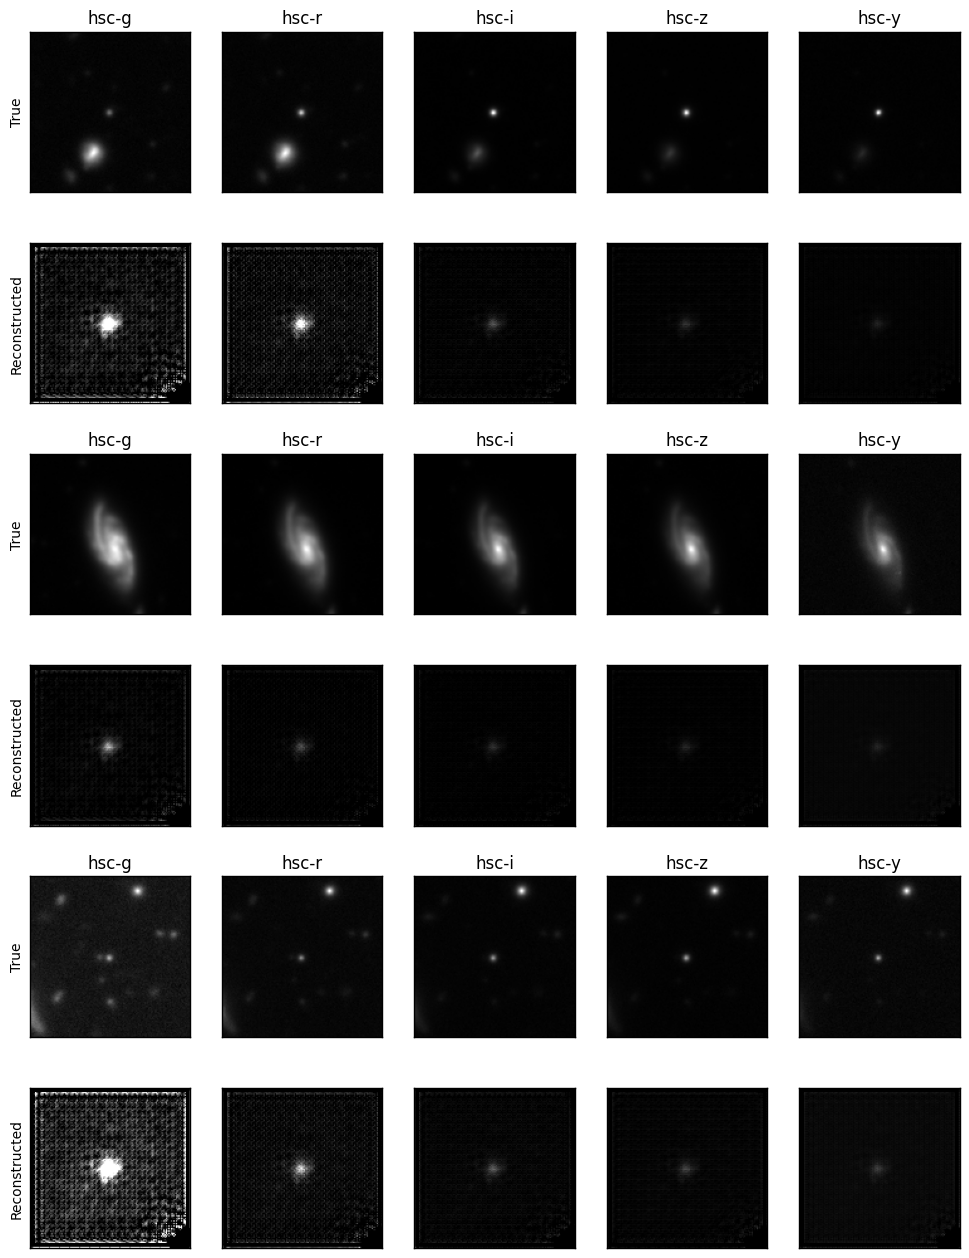

In [10]:
model.eval()
_n_plot = 3

imgs = torch.stack([dataset_test[i] for i in range(4)]).to(device)
with torch.no_grad():
    recs, _, _ = model(imgs)

fig, axs = plt.subplots(_n_plot * 2, n_bands, figsize=(12, 16))
for i in range(_n_plot):
    axs_row_true = axs[2 * i]
    axs_row_reco = axs[2 * i + 1]

    axs_row_true[0].set_ylabel("True")
    axs_row_reco[0].set_ylabel("Reconstructed")

    for j, band in enumerate(bands):
        minmax = {
            "vmin": imgs[i, j].cpu().min(),
            "vmax": imgs[i, j].cpu().max(),
        }
        axs_row_true[j].imshow(
            imgs[i, j].cpu(), origin="lower", cmap="gray", **minmax
        )
        axs_row_reco[j].imshow(
            recs[i, j].cpu(), origin="lower", cmap="gray", **minmax
        )

        axs_row_true[j].xaxis.set_ticks([])
        axs_row_true[j].yaxis.set_ticks([])
        axs_row_reco[j].xaxis.set_ticks([])
        axs_row_reco[j].yaxis.set_ticks([])
        axs_row_true[j].set_title(band)

In [ ]:
ds.max()